# Notebook to perform EDA on [MedQuAD](https://huggingface.co/datasets/lavita/MedQuAD) dataset and create dataset for RAG

In [1]:
from datasets import load_dataset
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import bs4 as soup
import requests
from tqdm import tqdm
import re

## Load the dataset and explore

In [3]:
ds = load_dataset("lavita/MedQuAD")

In [4]:
df_train = pd.DataFrame(ds['train'])
print(df_train.shape)

(47441, 13)


In [5]:
df_train.head(2)

,document_id,document_source,document_url,category,umls_cui,umls_semantic_types,umls_semantic_group,synonyms,question_id,question_focus,question_type,question,answer
0,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,None,C0343073,T047,Disorders,KWWH,0000559-1,keratoderma with woolly hair,information,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...
1,0000559,GHR,https://ghr.nlm.nih.gov/condition/keratoderma-...,None,C0343073,T047,Disorders,KWWH,0000559-2,keratoderma with woolly hair,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...


In [ ]:
doc_urls = df_train['document_url'].unique()
len(doc_urls)

11254

In [8]:
df_train['document_url'].describe()

count                                                47441
unique                                               11254
top       http://nihseniorhealth.gov/breastcancer/toc.html
freq                                                    28
Name: document_url, dtype: object

In [9]:
df_train['document_id'].describe()

count       47436
unique       5403
top       0000008
freq           79
Name: document_id, dtype: object

In [10]:
doc_ids = df_train['document_id'].unique()
len(doc_ids)

5404

In [11]:
print(doc_ids[0])
df_train[df_train['document_id'] == doc_ids[0]]['document_url'].values

0000559


array(['https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair',
       'https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair',
       'https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair',
       'https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair',
       'https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair',
       'https://rarediseases.info.nih.gov/gard/12439/autosomal-dominant-intermediate-charcot-marie-tooth-disease-type-c',
       'https://www.nlm.nih.gov/medlineplus/listeriainfections.html',
       'https://www.nlm.nih.gov/medlineplus/ency/article/003152.htm',
       'https://www.nlm.nih.gov/medlineplus/ency/article/003152.htm',
       'https://www.nlm.nih.gov/medlineplus/ency/article/003152.htm',
       'https://www.nlm.nih.gov/medlineplus/ency/article/003152.htm',
       'https://www.nlm.nih.gov/medlineplus/ency/article/003152.htm',
       'https://www.nlm.nih.gov/medlineplus/ency/article/003152.htm',
       'https://www.nlm

In [12]:
q_ids = df_train['question_id'].unique()
len(q_ids)

30086

## Scrape the data from the website

In [ ]:
def get_doc_content(document_url, f = None):
    """
    Scrape the webpage and return the content of the webpage
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36'
        }
    try:
        response = requests.get(document_url, headers=headers, timeout=20)
        if response.status_code == 200:
            page = soup.BeautifulSoup(response.content, 'html.parser')
            content = page.get_text()
            return content
        else:
            if f is not None:
                f.write(f'Error {response.status_code} in scraping {document_url}\n')
            else:
                print(f'Error {response.status_code} in scraping {document_url}')
            return None
    except Exception as e:
        if f is not None:
            f.write(f'Error in scraping {document_url}: {e}\n')
        else:
            print(f'Error in scraping {document_url}: {e}')
        return None

In [ ]:
# Test
idx = 0
url = doc_urls[0]
content = get_doc_content(url)
print(url)

https://ghr.nlm.nih.gov/condition/keratoderma-with-woolly-hair


In [14]:
# Replace multiple '\n' with single '\n'
content = re.sub(r'\n+', '\n', content)
content = content.strip()
print(content)

Keratoderma with woolly hair: MedlinePlus Genetics
Skip navigation
            An official website of the United States government
          
Here’s how you know
Here’s how you know
Official websites use .govA
              .gov website belongs to an official government
              organization in the United States.
            
Secure .gov websites use HTTPSA
              lock (
              
Lock
Locked padlock icon
 ) or https:// means you’ve safely connected to
              the .gov website. Share sensitive information only on official,
              secure websites.
            
 National Library of Medicine
Menu
Health Topics
Drugs & Supplements
Genetics
Medical Tests
Medical Encyclopedia
About MedlinePlus
Search
Search MedlinePlus
GO
About MedlinePlus
What's New
Site Map
Customer Support
Health TopicsDrugs & SupplementsGeneticsMedical TestsMedical Encyclopedia
You Are Here:
Home
			→
			
Genetics
					→
					
Genetic Conditions
					→
					
Keratoderma with woolly hair
URL 

### Scrape unique urls using multi-threading

In [ ]:
from concurrent.futures import ThreadPoolExecutor

f = open('errors.txt', 'w')

def fetch_and_process_content(url):
    content = get_doc_content(url, f)
    if content is not None:
        content = re.sub(r'\n+', '\n', content)
        content = content.strip()
        return {'document_url': url, 'document_content': content}
    return None

def process_urls_in_batches(urls):
    temp_list = []
    for url in urls:
        result = fetch_and_process_content(url)
        if result is not None:
            temp_list.append(result)
    return temp_list

# Split doc_urls into 64 batches
num_threads = 64
batches = [doc_urls[i::num_threads] for i in range(num_threads)]

li = []
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(tqdm(executor.map(process_urls_in_batches, batches), total=num_threads))

# Concatenate all temporary lists
for result in results:
    li.extend(result)

df = pd.DataFrame(li)
print(df.shape)

f.close()

100%|██████████| 64/64 [10:40<00:00, 10.00s/it]   

(7990, 2)


In [ ]:
# Urls which can't be scraped
len(doc_urls) - df.shape[0]

3264

In [19]:
df.head(2)

,document_url,document_content
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,Keratoderma with woolly hair: MedlinePlus Gene...
1,https://ghr.nlm.nih.gov/condition/kniest-dyspl...,Kniest dysplasia: MedlinePlus Genetics\nSkip n...


In [20]:
# df['document_content'] shouldn't be empty string
df[df['document_content'] == '']['document_url'].values

array([], dtype=object)

### Store unique documents

In [23]:
len(df['document_content'].unique())

7951

In [26]:
vc = df['document_content'].value_counts()
for doc_content, val in vc.items():
    if val > 1:
        print(df[df['document_content'] == doc_content]['document_url'].values)

['http://www.nhlbi.nih.gov/health/health-topics/topics/holes'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/chd'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/tof'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/heartmurmur'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/pda']
['http://www.nhlbi.nih.gov/health/health-topics/topics/hd'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/cad'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/cmd'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/dhd'
 'http://www.nhlbi.nih.gov/health/health-topics/topics/hdw']
['http://www.niddk.nih.gov/health-information/health-topics/Diabetes/causes-diabetes/Pages/index.aspx#type2'
 'http://www.niddk.nih.gov/health-information/health-topics/Diabetes/causes-diabetes/Pages/index.aspx'
 'http://www.niddk.nih.gov/health-information/health-topics/Diabetes/causes-diabetes/Pages/index.aspx#gestational'
 'http://www.niddk.nih.gov/health-information/health-topics/Di

**Observation:** Documents having the same content are the same webpages. They are actually the re-directs to the same webpage.

### Dataset creation
Create two dataframes:
1. **question_urls_df**: Contains the question and a list of the urls of the relevant documents
2. **urls_content_df**: Contains the url and the content of the document

In [29]:
doc_contents = set()
doc_to_parent = dict()
url_to_parent = dict()
url_to_content = dict()

for _, row in df.iterrows():
    url = row['document_url']
    doc_content = row['document_content']
    if doc_content in doc_contents:
        url_to_parent[url] = doc_to_parent[doc_content]
    else:
        doc_contents.add(doc_content)
        doc_to_parent[doc_content] = url
        url_to_parent[url] = url
        url_to_content[url] = doc_content

In [30]:
# Create url, content dataframe
df_url_content = pd.DataFrame(list(url_to_content.items()), columns=['document_url', 'document_content'])
print(df_url_content.shape)
df_url_content.head(2)

(7951, 2)


,document_url,document_content
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,Keratoderma with woolly hair: MedlinePlus Gene...
1,https://ghr.nlm.nih.gov/condition/kniest-dyspl...,Kniest dysplasia: MedlinePlus Genetics\nSkip n...


In [31]:
# Create question, document_url dataframe
ques_uniq = df_train['question'].unique()
len(ques_uniq)

44603

In [32]:
ques_ids = df_train['question_id'].unique()
len(ques_ids)

30086

In [33]:
df_train[df_train['question_id'] == ques_ids[0]]['question'].values

array(['What is (are) keratoderma with woolly hair ?',
       'What are the symptoms of Autosomal dominant intermediate Charcot-Marie-Tooth disease type C ?',
       'What is (are) Listeria Infections ?',
       'What is (are) Breast pain ?',
       'Who should get Glycopyrrolate and why is it prescribed ?'],
      dtype=object)

They are different questions

In [35]:
ques_url_li = []

for ques in ques_uniq:
    doc_urls = df_train[df_train['question'] == ques]['document_url'].values
    relevant_docs = set()
    for url in doc_urls:
        if url in url_to_parent:
            par_url = url_to_parent[url]
            relevant_docs.add(par_url)
    ques_url_li.append({
        'question': ques,
        'relevant_docs_urls': list(relevant_docs)
    })

df_ques_url = pd.DataFrame(ques_url_li)
print(df_ques_url.shape)
df_ques_url.head(2)

(44603, 2)


,question,relevant_docs_urls
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...


In [39]:
# Drop the rows where relevant_docs_urls is empty
df_ques_url = df_ques_url[df_ques_url['relevant_docs_urls'].apply(len) > 0]
print(df_ques_url.shape)
df_ques_url.head(2)

(37512, 2)


,question,relevant_docs_urls
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...


In [41]:
# A histogram of len of relevant_docs_urls
num_rel_docs = df_ques_url['relevant_docs_urls'].apply(len)
num_rel_docs.value_counts()

relevant_docs_urls
1    37090
2      394
3       22
4        5
5        1
Name: count, dtype: int64

## Number of tokens analysis

In [36]:
bge_base_model_name = "BAAI/bge-base-en-v1.5"
model = SentenceTransformer(bge_base_model_name)
model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained(bge_base_model_name)

## Number of tokens analysis for `nomic-ai/nomic-embed-text-v1` model

In [ ]:
# def trim_whitespaces(x):
#     """
#     Replaces multiple consecutive whitespace characters in the input string with a single space.

#     Args:
#         x (str): The input string to be processed.

#     Returns:
#         str: The processed string with consecutive whitespace characters replaced by a single space.
#     """
#     return re.sub(r'\s+', ' ', x)

def trim_whitespaces(x):
    """
    Replaces multiple consecutive space and tab characters in the input string with a single space,
    while retaining newline characters.

    Args:
        x (str): The input string to be processed.

    Returns:
        str: The processed string with consecutive space and tab characters replaced by a single space.
    """
    return re.sub(r'[ \t]+', ' ', x)

df_url_content['document_content'] = df_url_content['document_content'].apply(trim_whitespaces)

In [80]:
s = 'Hello\n   World'
trim_whitespaces(s)

'Hello\n World'

In [57]:
model_name = "nomic-ai/nomic-embed-text-v1"
# model = SentenceTransformer(model_name)
# model = model.to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name)

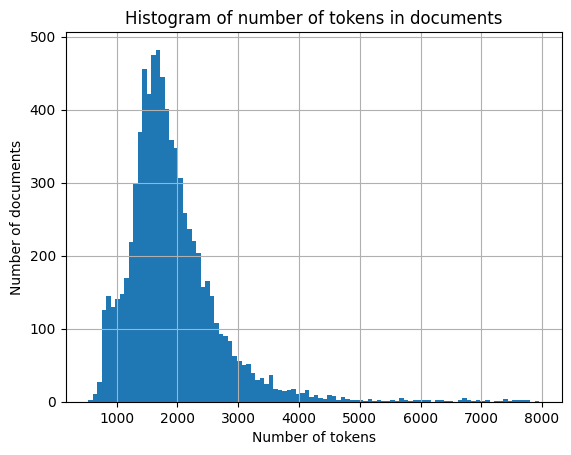

In [ ]:
# Plot a histogram of the number of tokens in the documents
doc_lengths = df_url_content['document_content'].apply(lambda x: len(tokenizer.encode(x)))
plt.hist(doc_lengths, bins=100)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.title('Histogram of number of tokens in documents')
plt.grid()
plt.show()

In [84]:
# Print min, max, mean, median number of tokens in the documents
print(f"Min number of tokens in the documents: {doc_lengths.min()}")
print(f"Max number of tokens in the documents: {doc_lengths.max()}")
print(f"Mean number of tokens in the documents: {doc_lengths.mean()}")
print(f"Median number of tokens in the documents: {doc_lengths.median()}")
print(f"99th percentile number of tokens in the documents: {doc_lengths.quantile(0.995)}")

Min number of tokens in the documents: 531
Max number of tokens in the documents: 7952
Mean number of tokens in the documents: 1918.5365172107201
Median number of tokens in the documents: 1770.0
99th percentile number of tokens in the documents: 6094.920000000009


## Final check

In [ ]:
for _, row in df_url_content.iterrows():
    # Check if all relevant urls are present in df_url_content_final
    rel_docs = row['relevant_docs_urls']
    for url in rel_docs:
        if url not in df_url_content['document_url'].values:
            print(f"Error: {url} not present in df_url_content_final")

In [ ]:
df_ques_url['question'].unique().shape

(36925,)

In [ ]:
df_url_content['document_url'].unique().shape

(7873,)

## Store the data as pickle files

In [ ]:
df_ques_url.to_pickle('data/questions_relevant_urls.pkl')

In [ ]:
df_url_content.to_pickle('data/docs_url_content_trimmed.pkl')